In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.metrics import roc_curve,auc

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#import data
feature_type = 'ATAC'
in_dir = feature_type+'_results/'
metadata_file = '../../../../../metadata/MBC/merged_key_metadata.txt'

probabilities = pd.read_csv(feature_type+'_results/probabilities.txt', sep='\t')
probabilities = probabilities.set_index('sample')

#merge in additional metadata as needed
print(len(probabilities))

metadata = pd.read_csv(metadata_file,sep='\t').set_index('sample')
metadata_columns = list(metadata.columns)

probabilities = probabilities.merge(metadata, left_index=True, right_index=True).copy()
print(len(probabilities))

n_iter = probabilities.drop(columns=['status']+metadata_columns).columns.values.astype('int').max()+1
print(n_iter)
probabilities[[m for m in range(n_iter)]] = probabilities[[str(m) for m in range(n_iter)]]
probabilities = probabilities.drop(columns = [str(m) for m in range(n_iter)])

254
254
1000


In [3]:
#export per sample probabilities
#this is also a supplementary table
probabilities['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)
probabilities['median_prediction'] = np.round(probabilities['median_probability']).astype(int)

probabilities[['median_probability','median_prediction']+metadata_columns].to_csv(feature_type+'_results/per_sample_means.txt', sep='\t')


In [4]:
for_supplement = probabilities[metadata_columns+['median_probability','median_prediction']].drop(columns = ['TNBC_ULPWGS_ID', 'PatientID_09204', 'PatientID_05246','merged_updated_ER_status_binary']).copy()
for_supplement.columns

rename_dict = {
    'merged_PrimaryEstrogenStatus':'primary_ER',
    'merged_MetsEstrogenStatus':'met_ER',
    'merged_ER_switch':'ER_switch',
    'merged_updated_ER_status':'ER_status',
    'merged_PrimaryProgesteroneStatus':'primary_PR',
    'merged_MetsProgesteroneStatus':'met_PR', 
    'merged_PR_switch':'PR_switch',
    'merged_TimeFromMet_ToDeathOrLastFU_Days':'TimeFromMet_ToDeathOrLastFU_Days',
    'merged_DeathCensor':'patient_death',
    'first_passing_sample':'first_sample',
    'median_probability':'probability_ER+',
    'median_prediction':'prediction'}

for_supplement = for_supplement.rename(columns=rename_dict)
for_supplement.to_csv(feature_type+'_results/S6_MBC_subtyping.txt', sep='\t')

In [5]:
#get unique samples only
probabilities = probabilities[probabilities['first_passing_sample']==1]
print(len(probabilities))
#print number of unique patients
print('unique patients', len(probabilities['patient_id'].unique()))
print('first TFx >0.1',len(probabilities[probabilities['tumor_fraction']>=0.1]['patient_id'].unique()))

139
unique patients 139
first TFx >0.1 101


In [6]:
print('all patients')
print(probabilities['status'].value_counts())

print('high tfx')
print(probabilities[probabilities['tumor_fraction']>=0.1]['status'].value_counts())

print('low tfx')
print(probabilities[probabilities['tumor_fraction']<0.1]['status'].value_counts())

all patients
1    74
0    65
Name: status, dtype: int64
high tfx
0    51
1    50
Name: status, dtype: int64
low tfx
1    24
0    14
Name: status, dtype: int64


In [7]:
#get AUC and accuracy for each bootstrap
AUCs = pd.DataFrame(columns = ['group','AUC'])
accuracies = pd.DataFrame(columns = ['group','accuracy'])
accuracy_df = pd.DataFrame(probabilities['status'])

for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][['status','tumor_fraction',i]].copy()
    
    current['accuracy'] = np.where(np.round(current[i])==current['status'],1,0)
    accuracy_df[i] = current['accuracy']
    low_tfx = current[(current['tumor_fraction']<0.1)]
    high_tfx = current[(current['tumor_fraction']>=0.1)]
    
    for group,df in zip(['overall','high_tfx','low_tfx'],[current,high_tfx,low_tfx]):
        fpr,tpr,_ = roc_curve(df['status'],df[i])
        
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
        accuracy = sum(np.round(df[i])==df['status'])/len(df)
        accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)

#frame is fragmented


In [8]:
#calculate confidence intervals
AUC_CI_df = AUCs.groupby('group').mean()
AUC_CI_df = AUC_CI_df.rename(columns = {'AUC':'mean'})

#get CI for each bootstrap
AUC_CI_df['lower'] = AUCs.groupby('group').quantile(.025)
AUC_CI_df['upper'] = AUCs.groupby('group').quantile(.975)
AUC_CI_df['metric']='AUC'

#calculate confidence intervals
accuracy_CI_df = accuracies.groupby('group').mean()
accuracy_CI_df = accuracy_CI_df.rename(columns = {'accuracy':'mean'})

#get CI for each bootstrap
accuracy_CI_df['lower'] = accuracies.groupby('group').quantile(.025)
accuracy_CI_df['upper'] = accuracies.groupby('group').quantile(.975)
accuracy_CI_df['metric']='accuracy'

#merge dataframes together
CI_df = accuracy_CI_df.append(AUC_CI_df).reset_index()

CI_df.to_csv(feature_type+'_results/CI_metrics.txt', sep='\t', index=False)

In [9]:
CI_df

,group,mean,lower,upper,metric
0,high_tfx,0.877400,0.777778,0.971429,accuracy
1,low_tfx,0.638566,0.375000,0.889035,accuracy
2,overall,0.811785,0.705882,0.903892,accuracy
3,high_tfx,0.929725,0.853731,0.994054,AUC
4,low_tfx,0.682526,0.339833,0.961120,AUC
5,overall,0.887415,0.810156,0.956354,AUC


In [10]:
accuracy_df['fraction_correct'] = accuracy_df[np.arange(n_iter)].mean(axis=1)
accuracy_df['median_accuracy'] = np.round(accuracy_df['fraction_correct']).astype(int)
accuracy_df['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)
accuracy_df['median_prediction'] = np.round(accuracy_df['median_probability']).astype(int)

sample_means = accuracy_df[['status','fraction_correct','median_probability','median_prediction','median_accuracy']].merge(metadata[metadata_columns], left_index=True, right_index=True)
sample_means[['status','tumor_fraction','fraction_correct','merged_ER_switch','merged_updated_ER_status_binary','median_probability','median_prediction','median_accuracy']].to_csv(feature_type+'_results/first_sample_means.txt', sep='\t')

In [11]:
data = sample_means
CI = CI_df

In [12]:
color_dict ={'low_tfx':'tab:olive','high_tfx':'tab:cyan', 'overall':'grey'}

0.6385657267130114
0.8774002275612276
0.8117852289006438


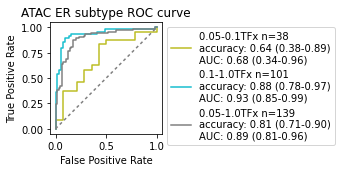

In [13]:
#plot the ROC curves 
fig,ax = plt.subplots(figsize=(6,2.5))

tfxs = [[.05,.1,'low_tfx'],[.1,1.0,'high_tfx'],[0.05,1.0,'overall']]


for minimum,maximum,name in tfxs:
    current = data[(data['tumor_fraction']>=minimum) & (data['tumor_fraction']<maximum)]

    accuracy = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['mean'].values[0]
    print(accuracy)
    
    AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['mean'].values[0]
    
    
    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
    #the AUC calculated this way isn't correct (slighlty higher)
    #auc_val = auc(fpr,tpr)
    #print(AUC, auc_val)
    
    #get the CI from the bootstrap data
    lower_acc = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['lower'].values[0]
    upper_acc = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['upper'].values[0]
    lower_AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['lower'].values[0]
    upper_AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['upper'].values[0]

    label = str(minimum)+'-'+str(maximum)+'TFx n='+str(len(current))+\
        '\naccuracy: '+ format(accuracy,'.2f')+' ('+format(lower_acc, '.2f')+'-'+format(upper_acc, '.2f')+')'+\
        '\nAUC: '+ format(AUC,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'

    
    
    plt.plot(fpr,tpr, label = label, color=color_dict[name])

plt.legend(bbox_to_anchor = [1,1], loc = 'upper left')
plt.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(feature_type+' ER subtype ROC curve')

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(in_dir+feature_type+'_ROC_curves_by_tfx.pdf')

In [14]:
#below here only use tfx>0.1
data = data[data['tumor_fraction']>=0.1]
print(len(data))

101


In [15]:
ER_negative_correct = data[(data['median_accuracy']==1) & (data['merged_updated_ER_status_binary']=='-')]
print('ER- correct\t', len(ER_negative_correct))

ER_negative_wrong = data[(data['median_accuracy']==0) & (data['merged_updated_ER_status_binary']=='-')]
print('ER- wrong\t',len(ER_negative_wrong))

ER_positive_correct = data[(data['median_accuracy']==1) & (data['merged_updated_ER_status_binary']=='+')]
print('ER+ correct\t',len(ER_positive_correct))

ER_positive_wrong = data[(data['median_accuracy']==0) & (data['merged_updated_ER_status_binary']=='+')]
print('ER+ wrong\t',len(ER_positive_wrong))

key_cols = ['tumor_fraction','merged_updated_ER_status_binary','median_probability','merged_ER_switch','merged_updated_ER_status','merged_MetsProgesteroneStatus']


ER- correct	 46
ER- wrong	 5
ER+ correct	 45
ER+ wrong	 5


In [16]:
#print the ER- wrong samples
ER_negative_wrong[['tumor_fraction','merged_updated_ER_status','median_probability','merged_ER_switch','merged_MetsProgesteroneStatus']]

#Three are subtype switchers

,tumor_fraction,merged_updated_ER_status,median_probability,merged_ER_switch,merged_MetsProgesteroneStatus
sample,,,,,
MBC_1158_ULP,0.5622,-,0.521014,loss,-
MBC_1370_1_ULP,0.1127,-,0.815967,same,+
MBC_1377_1_ULP,0.1504,-,0.562109,loss,-
MBC_1404_1_ULP,0.2463,-,0.709238,same,-
MBC_1413_2_ULP,0.3146,-,0.729495,loss,-


In [17]:
#print data about the ER negative correct samples
print(ER_negative_correct[['merged_ER_switch']].value_counts())
ER_negative_correct[ER_negative_correct['merged_ER_switch']=='loss']

merged_ER_switch
same                39
loss                 4
unknown              3
dtype: int64


,status,fraction_correct,median_probability,median_prediction,median_accuracy,patient_id,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,tumor_fraction,...,merged_MetsEstrogenStatus,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1099_4_ULP,0,0.652174,0.487797,0,1,MBC_1099,TNBC_ULPWGS_135,09204_982,05246_360,0.1669,...,-,loss,-,-,low,+,same,901.0,1.0,1.0
MBC_1399_3_ULP,0,1.000000,0.121332,0,1,MBC_1399,TNBC_ULPWGS_26,09204_991,NaN,0.1308,...,-,loss,-,-,+,-,loss,2917.0,1.0,1.0
MBC_1408_ULP,0,1.000000,0.253448,0,1,MBC_1408,TNBC_ULPWGS_86,09204_536,NaN,0.2757,...,-,loss,-,-,-,-,same,635.0,1.0,1.0
MBC_1412_1_ULP,0,1.000000,0.337341,0,1,MBC_1412,TNBC_ULPWGS_66,NaN,NaN,0.1416,...,-,loss,-,-,-,-,same,327.0,1.0,1.0


In [18]:
#look at ER switch patients
data[data['merged_ER_switch']=='loss'][['tumor_fraction','merged_updated_ER_status','median_probability','merged_ER_switch','merged_MetsProgesteroneStatus']]


,tumor_fraction,merged_updated_ER_status,median_probability,merged_ER_switch,merged_MetsProgesteroneStatus
sample,,,,,
MBC_1099_4_ULP,0.1669,-,0.487797,loss,+
MBC_1158_ULP,0.5622,-,0.521014,loss,-
MBC_1377_1_ULP,0.1504,-,0.562109,loss,-
MBC_1399_3_ULP,0.1308,-,0.121332,loss,-
MBC_1408_ULP,0.2757,-,0.253448,loss,-
MBC_1412_1_ULP,0.1416,-,0.337341,loss,-
MBC_1413_2_ULP,0.3146,-,0.729495,loss,-


In [19]:
#ER negative samples with positive HR
data[(data['merged_updated_ER_status_binary']=='-') & (data['merged_MetsProgesteroneStatus']=='+')]

,status,fraction_correct,median_probability,median_prediction,median_accuracy,patient_id,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,tumor_fraction,...,merged_MetsEstrogenStatus,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1099_4_ULP,0,0.652174,0.487797,0,1,MBC_1099,TNBC_ULPWGS_135,09204_982,05246_360,0.1669,...,-,loss,-,-,low,+,same,901.0,1.0,1.0
MBC_1370_1_ULP,0,0.000000,0.815967,1,0,MBC_1370,TNBC_ULPWGS_15,09204_914,NaN,0.1127,...,-,same,-,-,-,+,gain,1313.0,1.0,1.0


In [20]:
#perform a fishers exact test for subtype switch
no_switch_right = len(ER_negative_correct[ER_negative_correct['merged_ER_switch']=='same'])
switch_right = len(ER_negative_correct[ER_negative_correct['merged_ER_switch']=='loss'])

no_switch_wrong = len(ER_negative_wrong[ER_negative_wrong['merged_ER_switch']=='same'])
switch_wrong = len(ER_negative_wrong[ER_negative_wrong['merged_ER_switch']=='loss'])

contingency_table = [[no_switch_right,switch_right],[no_switch_wrong, switch_wrong]]
print(contingency_table)
oddsratio, pvalue = stats.fisher_exact(contingency_table)
oddsratio, pvalue

[[39, 4], [2, 3]]


(14.625, 0.01761135873069274)

41 39 2
7 4 3


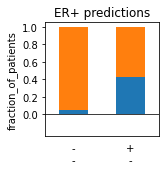

In [21]:
fig,ax = plt.subplots(figsize=(4,2.5))
padding = 0

pos_labels = ['+','borderline','low']
neg_labels = ['-']

for p,m in [['-','-'],['+','-']]:
    if p=='+':
        p_labels = pos_labels
    else:
        p_labels = neg_labels
    if m=='+':
        m_labels = pos_labels
    else:
        m_labels = neg_labels
    current = data[(data['merged_PrimaryEstrogenStatus'].isin(p_labels)) & (data['merged_MetsEstrogenStatus'].isin(m_labels))]
    group_label = p+'\n'+m
    rect = ax.bar(group_label, 1, color = 'tab:orange', label = 'predicted_ER_negative', width = 0.5)
    #ax.bar_label(rect, [len(current) - sum(current['median_prediction'])], padding=padding)
    rect = ax.bar(group_label, current['median_prediction'].mean(), color = 'tab:blue', label = 'predicted_ER_positive', width = 0.5)
    #ax.bar_label(rect, [sum(current['median_prediction'])], padding=padding)
    print(len(current),len(current) - sum(current['median_prediction']),sum(current['median_prediction']))

ax.set_ylabel('fraction_of_patients')
ax.set_title('ER+ predictions')


ax.set_ylim(-.25,1.05)
ax.set_xlim(-.5,1.5)
ax.axhline(0,color='black', linewidth = 0.75)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_yticks(np.arange(0,1.05,.2))
plt.tight_layout()
plt.tick_params(bottom = False)
fig.savefig(in_dir+'subtype_switch_barplot.pdf')

In [22]:
#ER positive

In [23]:
data[data['merged_ER_switch']=='gain']

,status,fraction_correct,median_probability,median_prediction,median_accuracy,patient_id,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,tumor_fraction,...,merged_MetsEstrogenStatus,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1274_ULP,1,0.991477,0.632928,1,1,MBC_1274,NaN,09204_27,NaN,0.1159,...,+,gain,+,+,-,-,same,1029.0,1.0,1.0


In [24]:
#look at the ER low samples
data[data['merged_updated_ER_status'].isin(['low','borderline','moderate'])][['tumor_fraction','median_probability','median_prediction','merged_updated_ER_status']]


,tumor_fraction,median_probability,median_prediction,merged_updated_ER_status
sample,,,,
MBC_1098_2_ULP,0.5718,0.821648,1,low
MBC_1116_3_ULP,0.3978,0.008323,0,low
MBC_1127_3_ULP,0.3016,0.739939,1,low
MBC_325.ctDNA_T2_ULP,0.1103,0.524698,1,low
MBC_331.ctDNA_ULP,0.4135,0.896522,1,low


In [25]:
#er positive wrong samples have one ER low
#1405 is an ER- patient, but they had multiple biopsies and the last one was ER+ (moderate)
ER_positive_wrong[['tumor_fraction','median_probability','merged_updated_ER_status','merged_PrimaryEstrogenStatus']]

,tumor_fraction,median_probability,merged_updated_ER_status,merged_PrimaryEstrogenStatus
sample,,,,
MBC_1092_3_ULP,0.1015,0.459495,+,+
MBC_1116_3_ULP,0.3978,0.008323,low,low
MBC_1149_4_ULP,0.3385,0.414332,+,+
MBC_1390_2_ULP,0.2021,0.259023,+,+
MBC_1405_4_ULP,0.2956,0.229925,+,+


In [26]:
ER_positive_correct['merged_updated_ER_status'].value_counts()

+      41
low     4
Name: merged_updated_ER_status, dtype: int64